In [1]:
import pandas as pd
import seaborn as sns
import toolbox as tbx
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Sommaire :

**1. Data Preprocessing**
- <a href="#C1">1.1. Description du jeu de données</a>
- <a href="#C2">1.2. Traitement des valeurs manquantes</a>
- <a href="#C3">1.3. Analyse univariée </a>


**2. Clustering (kmeans)**
- <a href="#C4">2.1. Analyse en Composantes Principales</a>
- <a href="#C5">2.2. Nombre optimal des clusters </a>
- <a href="#C6">2.3. Kmeans </a>

**3. Regression Logistique**
- <a href="#C7">3.1. Implémentation</a>
- <a href="#C8">3.2. Évaluation </a>
- <a href="#C9">3.3. Optimisation </a>

**4. Test des modèles**
- <a href="#C10"> 4.1. Préparation de l'échatillon</a>
- <a href="#C11"> 4.2. Implémentation de la fonction </a>
- <a href="#C12"> 4.3. Résultats des tests</a>

**5. Application Streamlit**
- <a href="#C13"> 5.1. Présentation de l'application.</a>


<h2><center>Contexte</center></h2> 

Ce projet consiste à prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées de la ville de Seattle.

Cette prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)


Nous avons à notre disposition un jeu de données contenant les réléés de 2016. 
</br>
<br>


TAF :
1. Réaliser une courte analyse exploratoire.
2. Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

*********************************** Data infos ***********************************
Nombre de colonnes :  46 

Nombre de lignes :  3376 


 ********************************** Valeurs manquantes **********************************


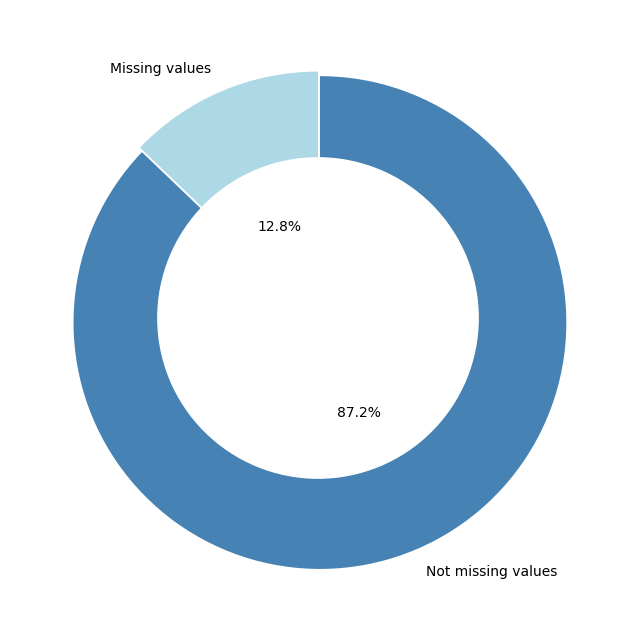

Nombre total de valeurs manquantes :  19952 

************************* Clés primaires candidates *************************
['OSEBuildingID']
['OSEBuildingID', 'DataYear']
['OSEBuildingID', 'BuildingType']
Nombre maximum autorisé atteint. Veuillez augmenter cette valeur si vous voulez rechercher davantage de clés primaires candidates.

************************* Rapport des doublons *************************

Nombre de doublons :  0


In [19]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
display(df.head())
tbx.describe_data(df)
print('*'*25, 'Clés primaires candidates','*'*25)
tbx.cles_potentielles(df, max_allowed=2)
print()
print('*'*25, 'Rapport des doublons','*'*25)
print()
print('Nombre de doublons : ',len(df[df.duplicated(subset='OSEBuildingID')]))

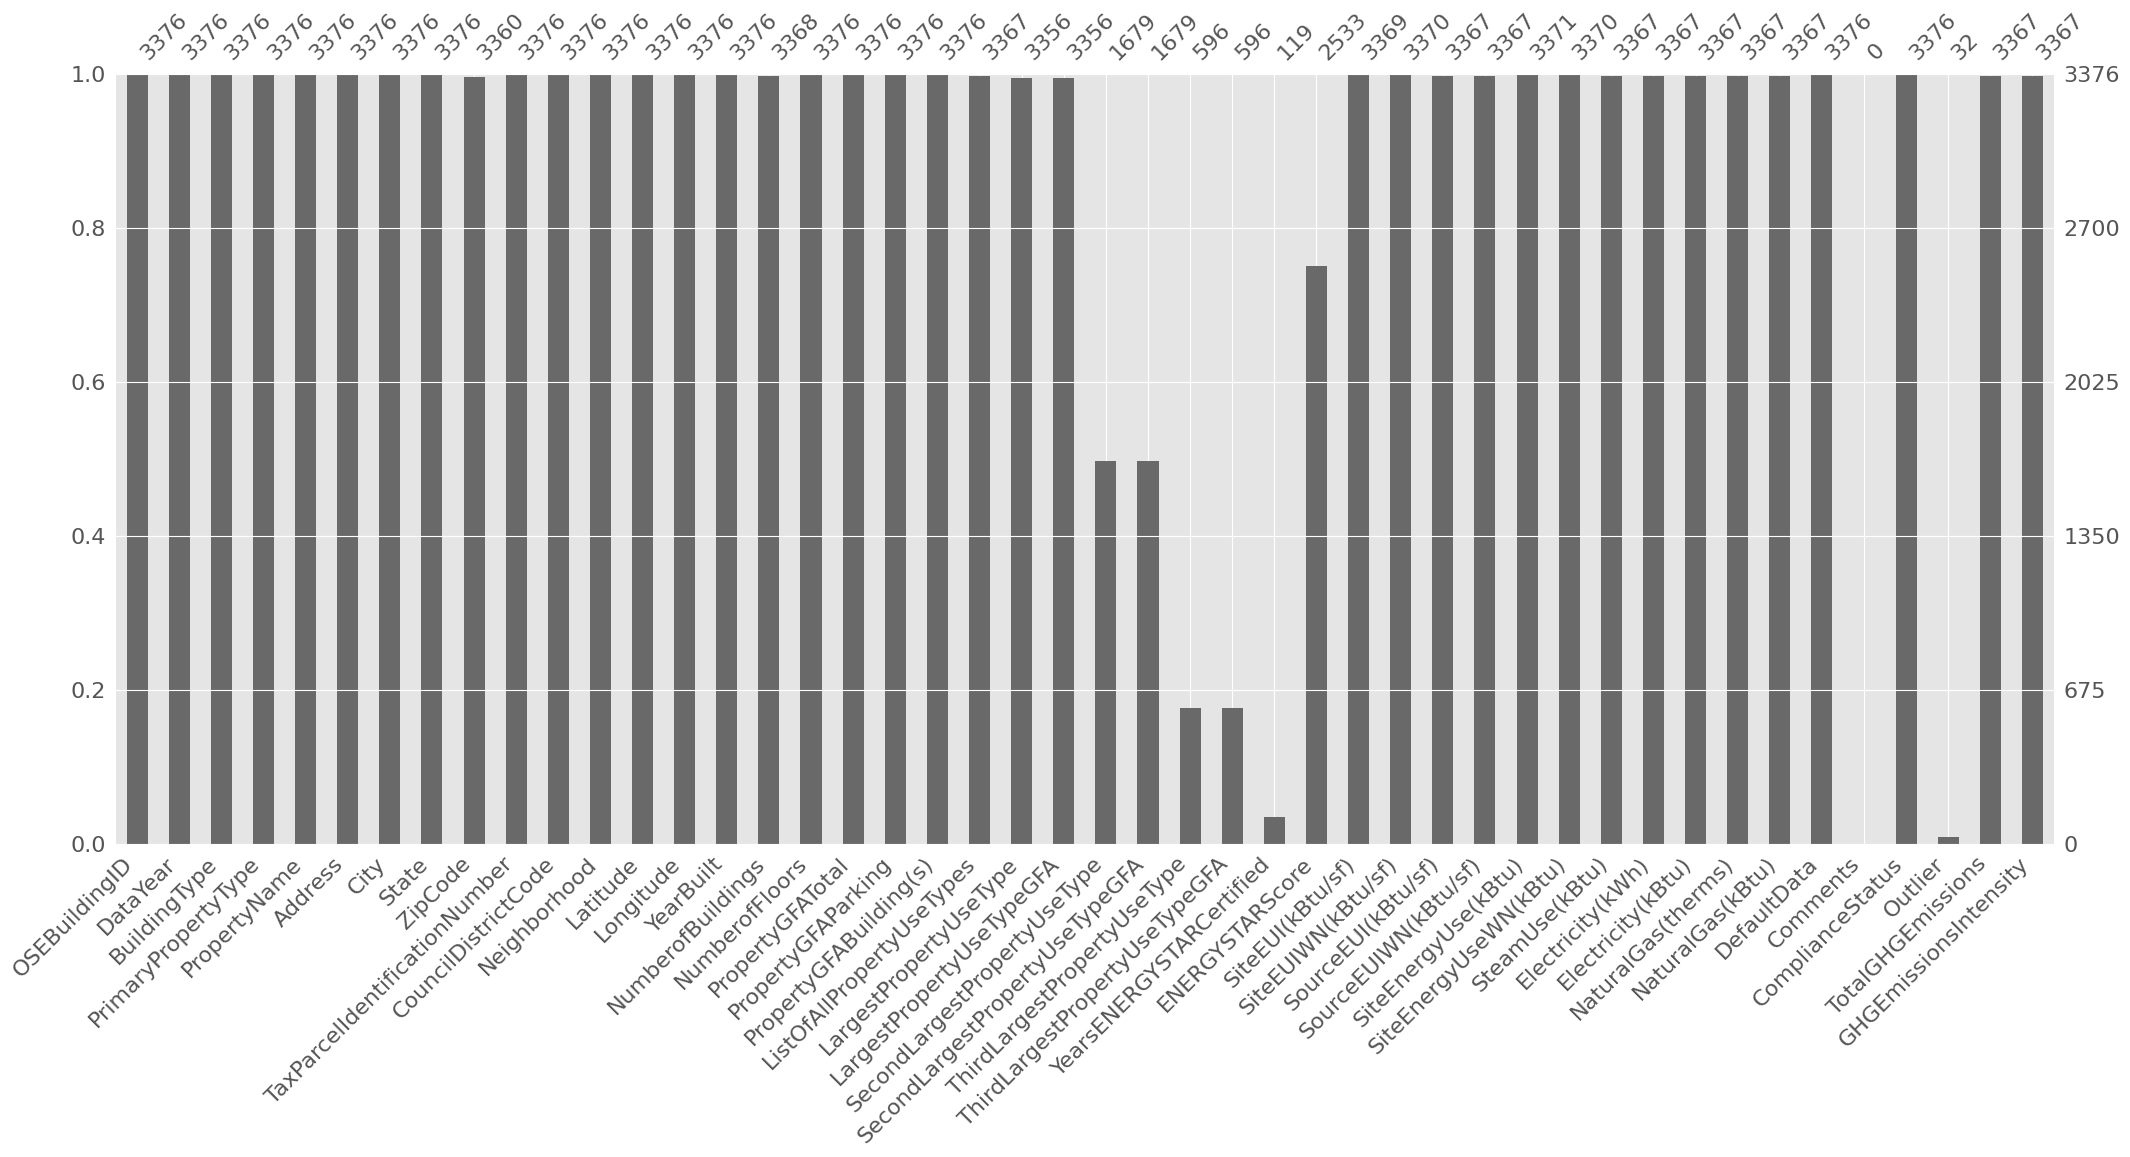

### Batiments destinés à l'habiation

In [34]:
habitation = df[df["BuildingType"].isin([elem for elem in df["BuildingType"].unique() if 'family' in elem])]
print('''Rapport des batiments destinés à l'habitation''')
print('Nombre de batiments :',(len(habitation)))
display(habitation.head())

Rapport des batiments destinés à l'habitation
Nombre de batiments : 1708


OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
9               13      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
165            265      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
173            280      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   
188            296      2016  Multifamily LR (1-4)  Low-Rise Multifamily   
189            297      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   

                     PropertyName               Address     City State  \
9                   Lyon Building        607 - 3rd Ave.  Seattle    WA   
165        YWCA Opportunity Place       2024 3rd Avenue  Seattle    WA   
173                      Wintonia        1431 Minor Ave  Seattle    WA   
188  Cooper School Artist's Lofts  4408 Delridge Way SW  Seattle    WA   
189               LAKE CITY COURT     12730 33RD AVE NE  Seattle    WA   

     ZipCode TaxParcelIdentificationNumber  ...  Electricity(kWh)  \
9    98104.0                    0939000105  ...      7.420912e+05   
165  98121.0                    8729690000  ...      1.612728e+06   
173  98101.0                    8725600350  ...      4.903724e+05   
188  98106.0                    3388120000  ...      3.493257e+05   
189  98125.0                    3993000000  ...      4.558248e+05   

    Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
9           2532015.0        10020.259770         1002026.0        False   
165         5502627.0        45374.941410         4537494.0        False   
173         1673151.0        25164.187500         2516419.0        False   
188         1191899.0         7947.119629          794712.0        False   
189         1555274.0         9186.879883          918688.0        False   

     Comments  ComplianceStatus  Outlier  TotalGHGEmissions  \
9         NaN         Compliant      NaN             151.12   
165       NaN         Compliant      NaN             279.35   
173       NaN         Compliant      NaN             145.31   
188       NaN         Compliant      NaN              50.52   
189       NaN         Compliant      NaN              59.63   

     GHGEmissionsIntensity  
9                     2.37  
165                   2.39  
173                   2.80  
188                   0.89  
189                   1.05  

[5 rows x 46 columns]

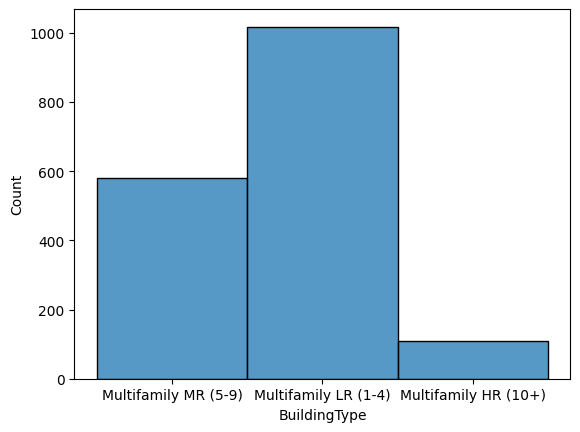

In [35]:
sns.histplot(data=habitation, x='BuildingType', )
plt.show()

### Batiments à considérer pour l'analyse

Rapport des batiments à considérer
Nombre de batiments : 1668


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

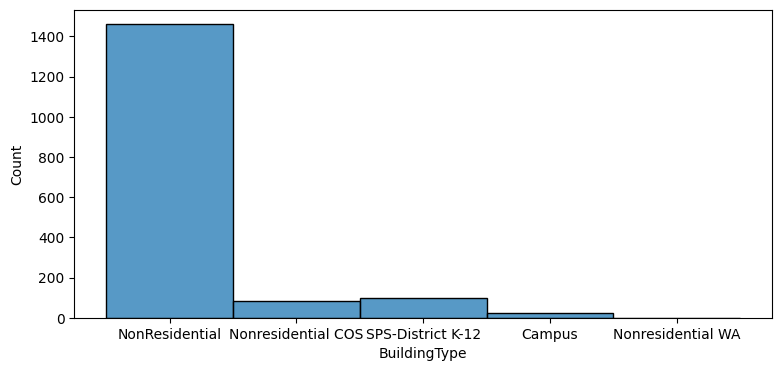

In [39]:
data = df[~df["BuildingType"].isin([elem for elem in df["BuildingType"].unique() if 'family' in elem])]
print('''Rapport des batiments à considérer''')
print('Nombre de batiments :',(len(data)))
display(data.head())
plt.figure(figsize=(9,4))
sns.histplot(data=data, x='BuildingType', )
plt.show()

In [63]:
import folium

m = folium.Map()
m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()],
               zoom_start=11)
for i in range(0,len(data)):
    folium.Circle([data.iloc[i]['Latitude'],data.iloc[i]['Longitude']], popup=data.iloc[i]['Address'], radius =100).add_to(m)
m

************************* Compliance report *************************
Rapport des batiments conformes
Nombre de batiments : 1548


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

Rapport des batiments conformes
Nombre de batiments : 120


OSEBuildingID  DataYear       BuildingType PrimaryPropertyType  \
22             28      2016  SPS-District K-12         K-12 School   
28             34      2016  SPS-District K-12         K-12 School   
30             36      2016  SPS-District K-12         K-12 School   
31             37      2016  SPS-District K-12         K-12 School   
38             51      2016  SPS-District K-12         K-12 School   

              PropertyName               Address     City State  ZipCode  \
22  Graham Hill Elementary    5149 S. Graham St.  Seattle    WA  98118.0   
28          Meany Building  301/300 21st Ave. E.  Seattle    WA  98112.0   
30      Jane Addams Middle  11051 34th Ave. N.E.  Seattle    WA  98125.0   
31     John Hay Elementary      201 Garfield St.  Seattle    WA  98109.0   
38         Eckstein Middle    3003 N.E. 75th St.  Seattle    WA  98115.0   

   TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
22                    1102000138  ...       274605.9063          936955.0   
28                    0688000090  ...            0.0000               0.0   
30                    0752000170  ...       570809.1875         1947601.0   
31                    0809000005  ...       438691.6875         1496816.0   
38                    0425049022  ...       468840.5000         1599684.0   

    NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
22         6025.229004          602523.0         True       NaN   
28            0.000000               0.0        False       NaN   
30        48315.718750         4831572.0         True       NaN   
31            0.000000               0.0        False       NaN   
38        47994.433590         4799443.0         True       NaN   

                ComplianceStatus  Outlier  TotalGHGEmissions  \
22  Error - Correct Default Data      NaN              38.53   
28                  Missing Data      NaN               0.00   
30  Error - Correct Default Data      NaN             270.18   
31                  Missing Data      NaN              10.43   
38  Error - Correct Default Data      NaN             266.05   

    GHGEmissionsIntensity  
22                   0.69  
28                   0.00  
30                   1.68  
31                   0.20  
38                   1.52  

[5 rows x 46 columns]

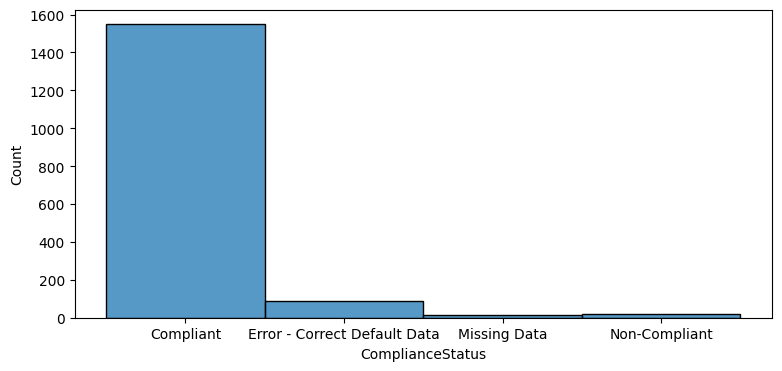

In [61]:
print('*'*25,'Compliance report','*'*25)
# batiments conformes
conforme =data[data['ComplianceStatus'] == "Compliant"]
print('''Rapport des batiments conformes''')
print('Nombre de batiments :',(len(conforme)))
display(conforme.head())

# batiments non conformes
non_conforme =data[data['ComplianceStatus'] != "Compliant"]
non_conforme =data[data['ComplianceStatus'] != "Compliant"]
print('''Rapport des batiments conformes''')
print('Nombre de batiments :',(len(non_conforme)))
display(non_conforme.head())

#plot
plt.figure(figsize=(9,4))
sns.histplot(data=data, x='ComplianceStatus', )
plt.show()

In [97]:
data_conforme = conforme.copy()

In [100]:
# data cleaning
useless_columns = [
                    "DataYear",
                    "OSEBuildingID",
                    "Comments", 
                    "ComplianceStatus", 
                    "CouncilDistrictCode",
                    "DefaultData",
                    "PropertyName", 
                    "TaxParcelIdentificationNumber", 
                    "ZipCode", 
                    "Address"]

# pour les tests
redundant_columns  = [
                    'Electricity(kWh)', 
                    'NaturalGas(therms)',
                    'SiteEUI(kBtu/sf)', 
                    'SiteEUIWN(kBtu/sf)', 
                    'SourceEUI(kBtu/sf)',
                    'SourceEUIWN(kBtu/sf)', 
                    'SiteEnergyUseWN(kBtu)', 
                    'GHGEmissionsIntensity'
                    ]

data_conforme[useless_columns + redundant_columns].head()

DataYear  OSEBuildingID  Comments ComplianceStatus  CouncilDistrictCode  \
0      2016              1       NaN        Compliant                    7   
1      2016              2       NaN        Compliant                    7   
2      2016              3       NaN        Compliant                    7   
3      2016              5       NaN        Compliant                    7   
4      2016              8       NaN        Compliant                    7   

   DefaultData                 PropertyName TaxParcelIdentificationNumber  \
0        False         Mayflower park hotel                    0659000030   
1        False              Paramount Hotel                    0659000220   
2        False      5673-The Westin Seattle                    0659000475   
3        False                    HOTEL MAX                    0659000640   
4        False  WARWICK SEATTLE HOTEL (ID8)                    0659000970   

   ZipCode          Address  Electricity(kWh)  NaturalGas(therms)  \
0  98101.0    405 Olive way      1.156514e+06         12764.52930   
1  98101.0  724 Pine street      9.504252e+05         51450.81641   
2  98101.0  1900 5th Avenue      1.451544e+07         14938.00000   
3  98101.0   620 STEWART ST      8.115253e+05         18112.13086   
4  98121.0    401 LENORA ST      1.573449e+06         88039.98438   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           97.900002          176.100006   
2         96.000000           97.699997          241.899994   
3        110.800003          113.300003          216.199997   
4        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  GHGEmissionsIntensity  
0            189.000000              7456910.0                   2.83  
1            179.399994              8664479.0                   2.86  
2            244.100006             73937112.0                   2.19  
3            224.000000              6946800.5                   4.67  
4            215.600006             14656503.0                   2.88

In [101]:
data_conforme.drop(redundant_columns + useless_columns, inplace=True, axis=1)

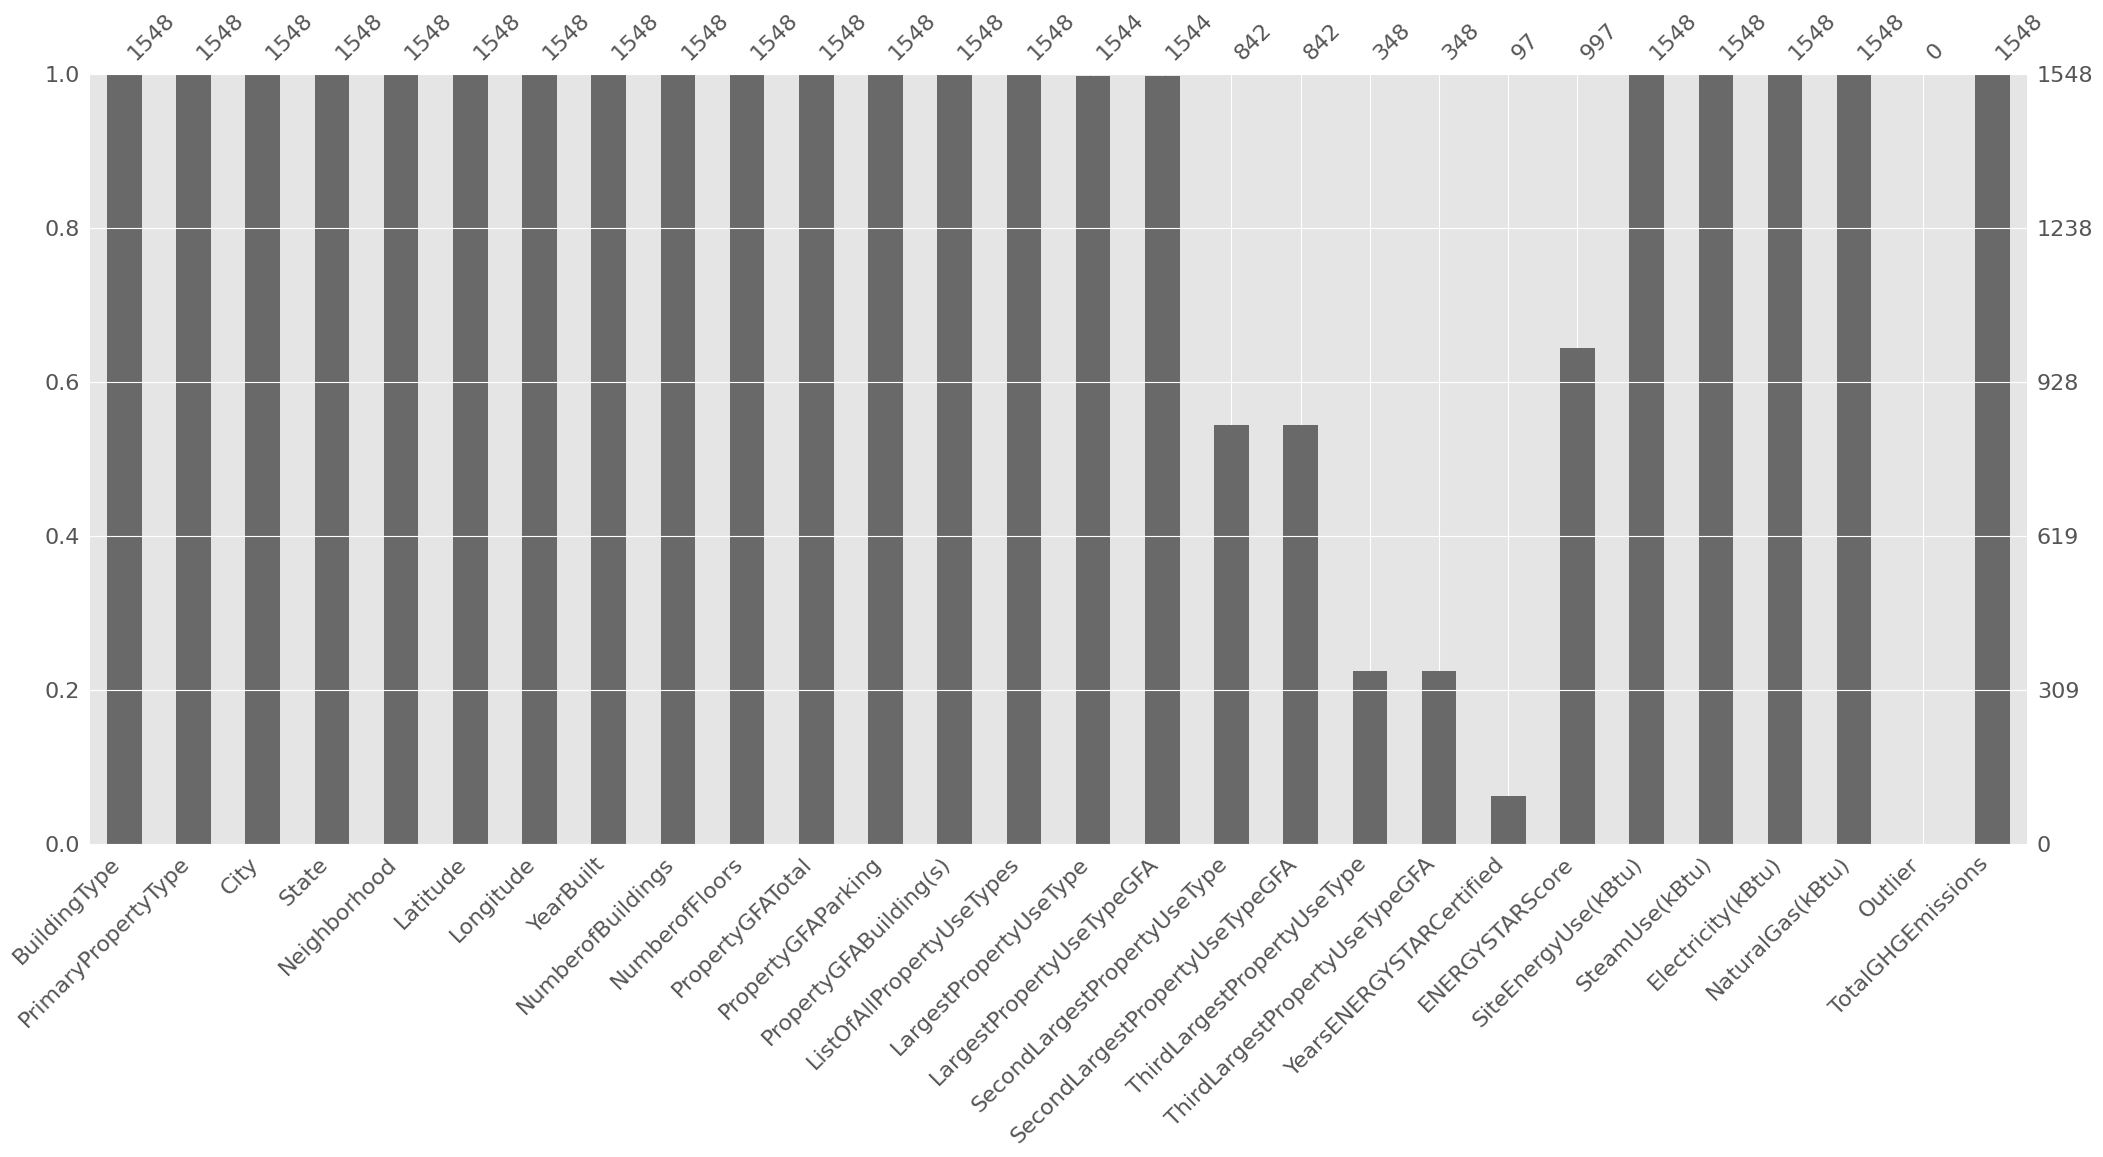

In [118]:
msno.bar(data_conforme)
plt.show()

In [ ]:
data[:, (1-total_data.isnull().mean()) >=.20]


In [115]:
data_conforme.describe()

Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  1548.000000  1548.000000  1548.000000        1548.000000   
mean     47.616488  -122.333518  1961.644057           1.178941   
std       0.046954     0.023264    32.886918           3.039221   
min      47.509590  -122.411820  1900.000000           0.000000   
25%      47.587855  -122.342997  1930.000000           1.000000   
50%      47.612710  -122.333160  1965.500000           1.000000   
75%      47.649060  -122.322700  1989.000000           1.000000   
max      47.733870  -122.261800  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     1548.000000      1.548000e+03         1548.000000   
mean         4.276486      1.213321e+05        13842.337209   
std          6.780694      3.062944e+05        43721.822291   
min          0.000000      1.128500e+04            0.000000   
25%          1.000000      2.884325e+04            0.000000   
50%          2.000000      4.815900e+04            0.000000   
75%          4.000000      1.076615e+05            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            1.548000e+03               1.544000e+03   
mean             1.074898e+05               9.994564e+04   
std              2.926272e+05               2.855014e+05   
min              3.636000e+03               5.656000e+03   
25%              2.793675e+04               2.501575e+04   
50%              4.608400e+04               4.204300e+04   
75%              9.556825e+04               9.203675e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                       842.000000                      348.000000   
mean                      36342.497977                    14998.889077   
std                       66631.152358                    37037.015147   
min                           0.000000                        0.000000   
25%                        5564.250000                     2624.250000   
50%                       12062.500000                     5965.500000   
75%                       31820.250000                    12965.500000   
max                      639931.000000                   459748.000000   

       ENERGYSTARScore  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
count       997.000000         1.548000e+03    1.548000e+03   
mean         63.635908         8.860058e+06    5.511831e+05   
std          28.825309         3.130568e+07    5.718502e+06   
min           1.000000         5.713320e+04    0.000000e+00   
25%          44.000000         1.251083e+06    0.000000e+00   
50%          71.000000         2.732167e+06    0.000000e+00   
75%          88.000000         7.294487e+06    0.000000e+00   
max         100.000000         8.739237e+08    1.349435e+08   

       Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
count       1.548000e+03      1.548000e+03        1548.000000  
mean        6.140840e+06      2.038297e+06         193.608908  
std         2.151071e+07      9.710667e+06         779.105278  
min        -1.154170e+05      0.000000e+00          -0.800000  
25%         7.308642e+05      0.000000e+00          20.655000  
50%         1.746086e+06      4.881350e+05          49.845000  
75%         5.264935e+06      1.530812e+06         147.227500  
max         6.570744e+08      2.979090e+08       16870.980000

In [103]:
numerical_features= list(data_conforme.select_dtypes(include=["float64","int64"]).columns)

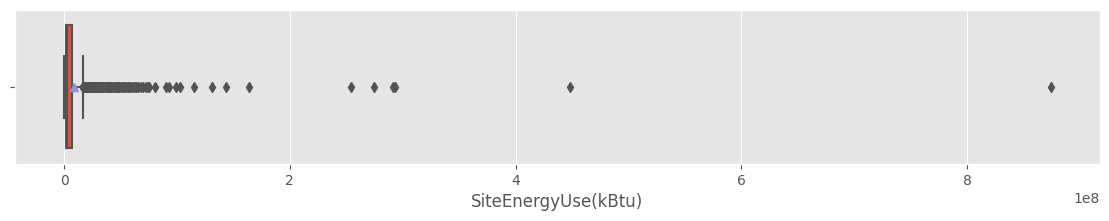

In [114]:
plt.figure(figsize=(14,2))
sns.boxplot(data=data_conforme, x="SiteEnergyUse(kBtu)", showmeans=True,showfliers=True,)
plt.show()

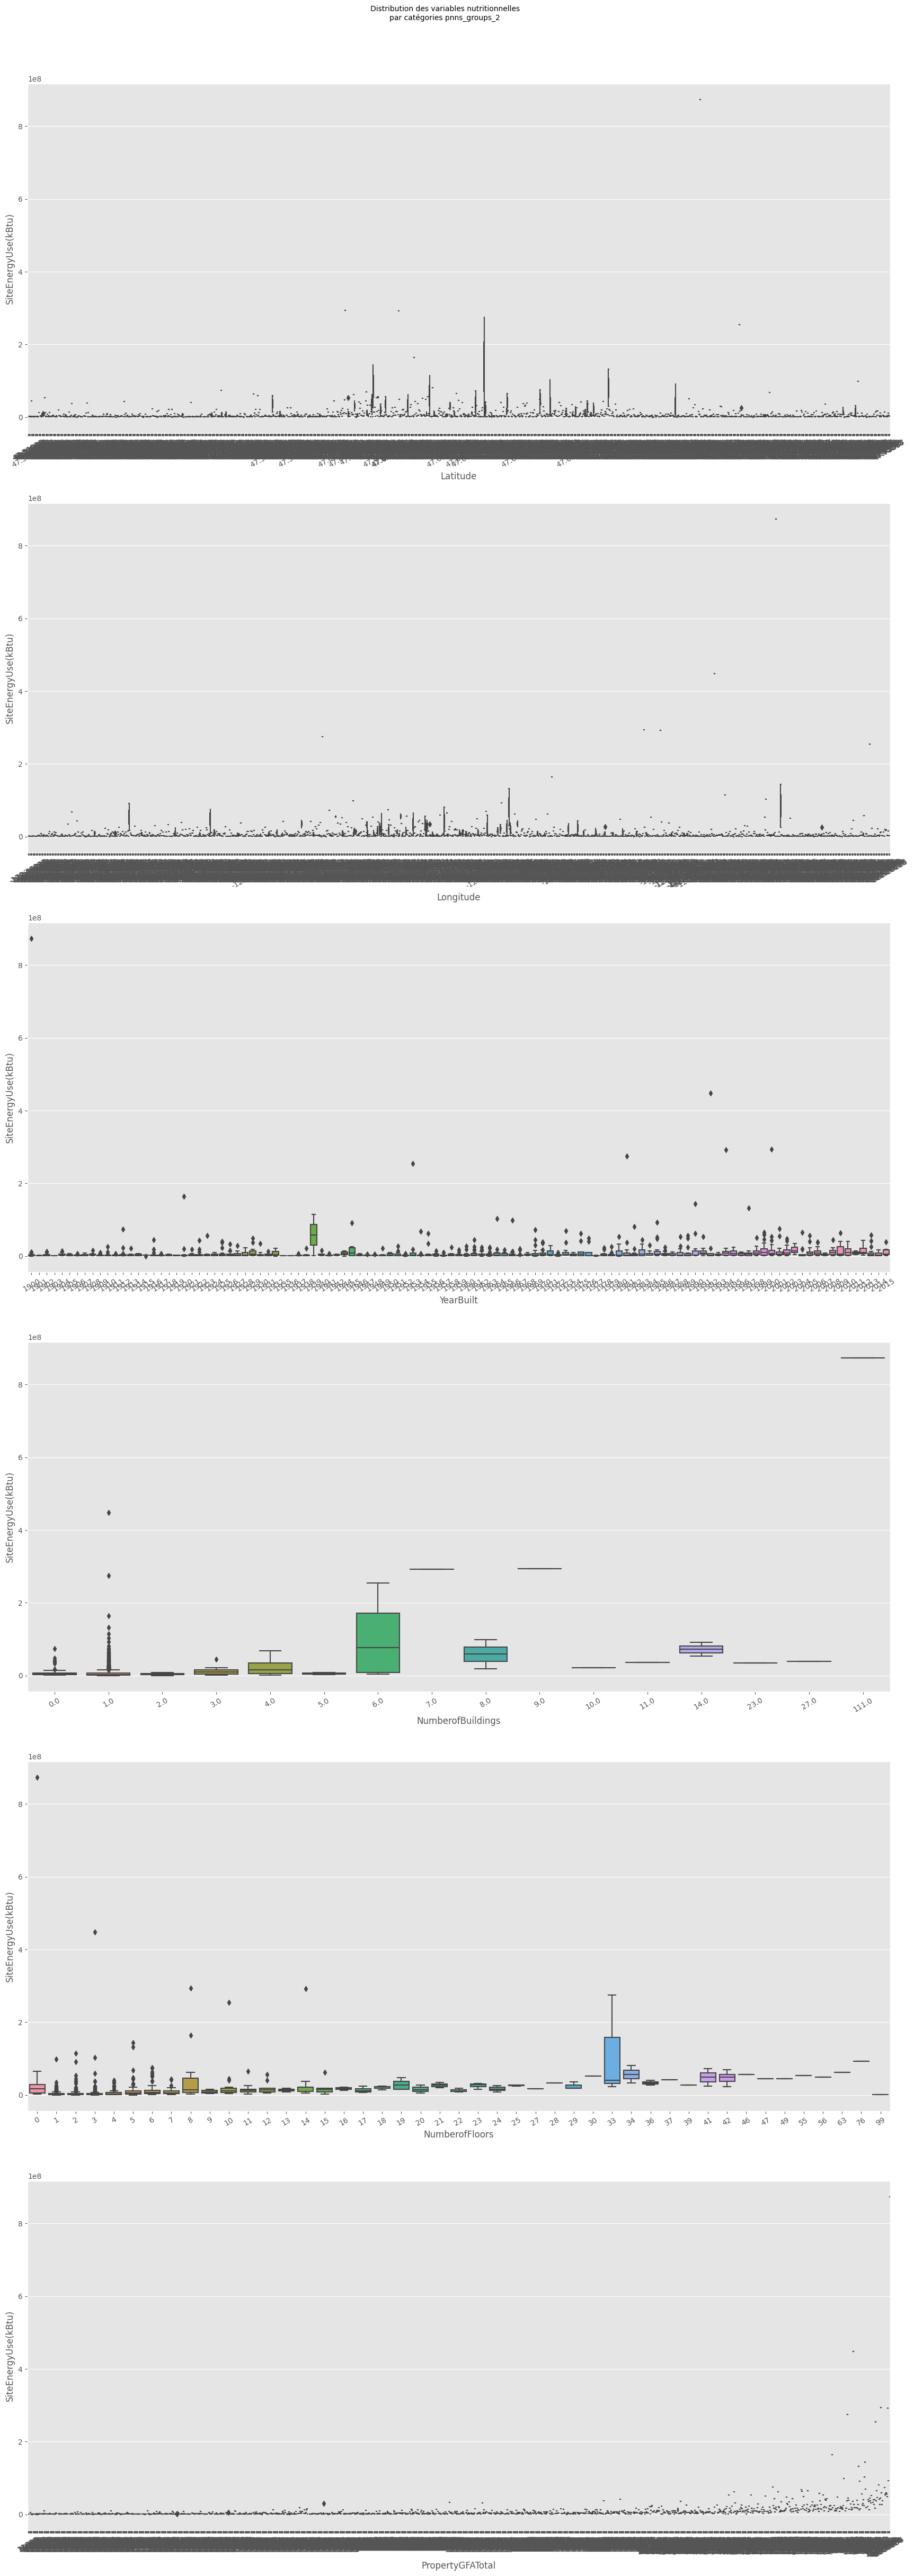

In [105]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,60))

sub = 0
for i in range(len(numerical_features[:6])):
    fig.add_subplot(6,1,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(y="SiteEnergyUse(kBtu)", x=colonne, data=data_conforme)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_2", ha="center", )
plt.show()

In [ ]:
for elem in numerical_features :
    

<AxesSubplot: xlabel='Count', ylabel='ComplianceStatus'>

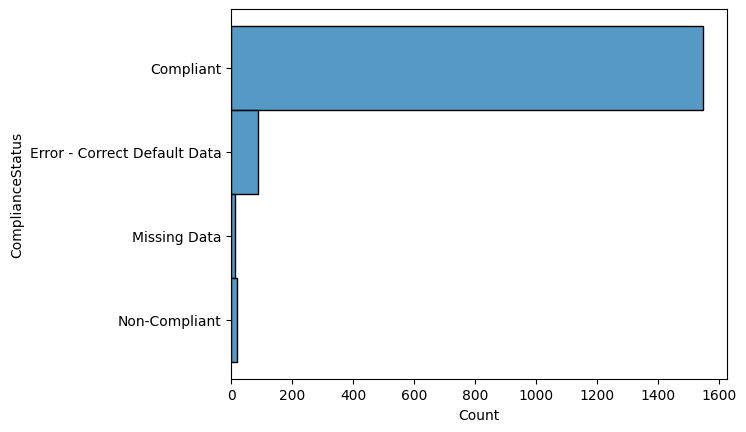

In [54]:
#plt.figure(figsize=(9,4))
sns.histplot(data=data, y='ComplianceStatus')

In [57]:
data[data['ComplianceStatus'] != "Compliant"]

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
22               28      2016   SPS-District K-12         K-12 School   
28               34      2016   SPS-District K-12         K-12 School   
30               36      2016   SPS-District K-12         K-12 School   
31               37      2016   SPS-District K-12         K-12 School   
38               51      2016   SPS-District K-12         K-12 School   
...             ...       ...                 ...                 ...   
3152          43948      2016  Nonresidential COS               Other   
3166          49703      2016   SPS-District K-12         K-12 School   
3366          50210      2016  Nonresidential COS              Office   
3369          50220      2016  Nonresidential COS              Office   
3371          50222      2016  Nonresidential COS              Office   

                      PropertyName                 Address     City State  \
22          Graham Hill Elementary      5149 S. Graham St.  Seattle    WA   
28                  Meany Building    301/300 21st Ave. E.  Seattle    WA   
30              Jane Addams Middle    11051 34th Ave. N.E.  Seattle    WA   
31             John Hay Elementary        201 Garfield St.  Seattle    WA   
38                 Eckstein Middle      3003 N.E. 75th St.  Seattle    WA   
...                            ...                     ...      ...   ...   
3152         Georgetown Steamplant  6605 13th Avenue South  Seattle    WA   
3166          Catharine Blaine K-8       2550 34th Ave. W.  Seattle    WA   
3366  Central West HQ / Brown Bear             1403 w howe  Seattle    WA   
3369              Genesee/SC SE HQ          4420 S Genesee  Seattle    WA   
3371         Horticulture building        1600 S Dakota St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  ...  Electricity(kWh)  \
22    98118.0                    1102000138  ...      274605.90630   
28    98112.0                    0688000090  ...           0.00000   
30    98125.0                    0752000170  ...      570809.18750   
31    98109.0                    0809000005  ...      438691.68750   
38    98115.0                    0425049022  ...      468840.50000   
...       ...                           ...  ...               ...   
3152  98108.0                    0000000000  ...       21210.59961   
3166  98199.0                    2225039016  ...           0.00000   
3366      NaN                    2425039137  ...      147323.50000   
3369      NaN                    4154300585  ...       81341.39844   
3371      NaN                    1624049080  ...      153655.00000   

     Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
22        9.369550e+05         6025.229004      6.025230e+05         True   
28        0.000000e+00            0.000000      0.000000e+00        False   
30        1.947601e+06        48315.718750      4.831572e+06         True   
31        1.496816e+06            0.000000      0.000000e+00        False   
38        1.599684e+06        47994.433590      4.799443e+06         True   
...                ...                 ...               ...          ...   
3152      7.237100e+04            0.000000      0.000000e+00        False   
3166      0.000000e+00        49936.195310      4.993620e+06        False   
3366      5.026678e+05            0.000000      0.000000e+00         True   
3369      2.775369e+05         1102.729980      1.102730e+05         True   
3371      5.242709e+05         3254.750244      3.254750e+05         True   

      Comments              ComplianceStatus      Outlier  TotalGHGEmissions  \
22         NaN  Error - Correct Default Data          NaN              38.53   
28         NaN                  Missing Data          NaN               0.00   
30         NaN  Error - Correct Default Data          NaN             270.18   
31         NaN                  Missing Data          NaN              10.43   
38         NaN  Error - Correct Defaul

In [40]:
#df.YearBuilt=pd.Categorical(df.YearBuilt)
#df.ZipCode=pd.Categorical(df.ZipCode)
numerical_features = list(data.select_dtypes(include=["float64","int64"]).columns)
categorical_features = [x for x in data.columns if x not in numerical_features ]

In [18]:
relevant_categorical_features = ['BuildingType',
                                 'PrimaryPropertyType',
                                 'ZipCode',
                                 'Neighborhood',
                                 'YearBuilt',]

In [9]:
target = 'SiteEnergyUse(kBtu)'
#features = ['BuildingType', 'PrimaryPropertyType','ZipCode','Neighborhood','YearBuilt']

In [ ]:
pd.get_dummies(data=df, columns=features)

In [10]:
#On prépare le modèle
import statsmodels.formula.api as smf
model_reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(model_reg_multi.summary())

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

<AxesSubplot: xlabel='count', ylabel='NumberofBuildings'>

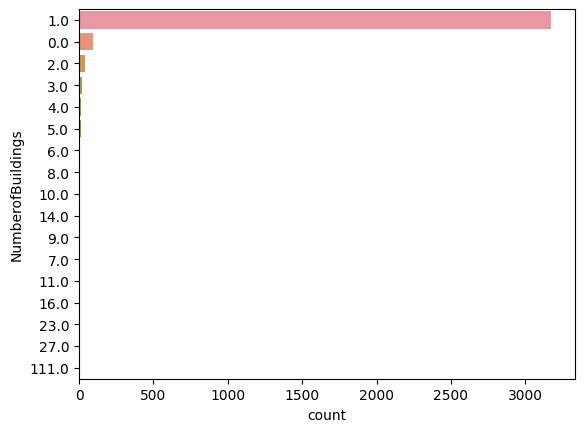

In [64]:
sns.countplot(data=df, y='NumberofBuildings', order=df['NumberofBuildings'].value_counts().index)

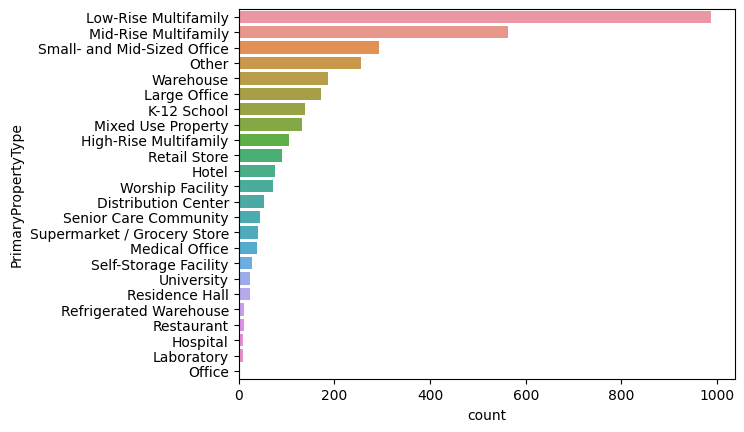

In [5]:
sns.countplot(data=df, y='PrimaryPropertyType', order=df['PrimaryPropertyType'].value_counts().index)
plt.show()

<AxesSubplot: xlabel='count', ylabel='BuildingType'>

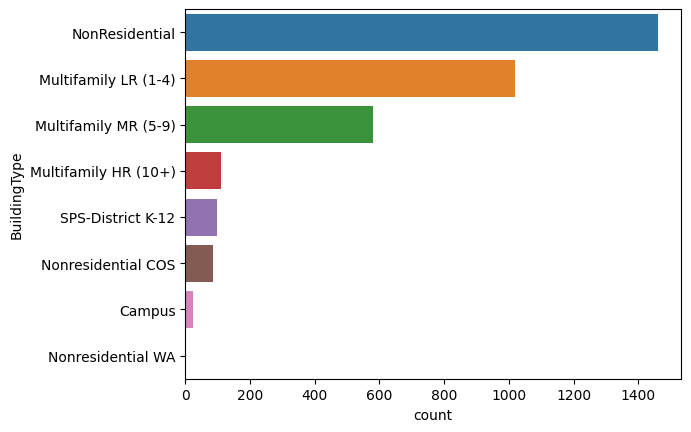

In [9]:
sns.countplot(data=df, y='BuildingType', order=df['BuildingType'].value_counts().index)

<AxesSubplot: xlabel='count', ylabel='Neighborhood'>

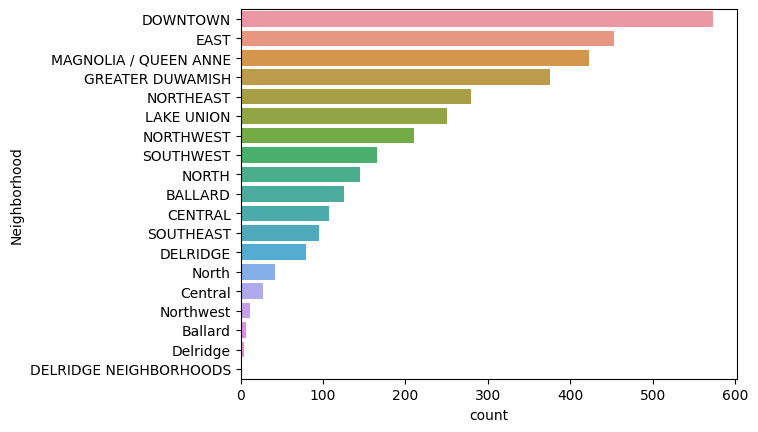

In [10]:
sns.countplot(data=df, y='Neighborhood', order=df['Neighborhood'].value_counts().index)

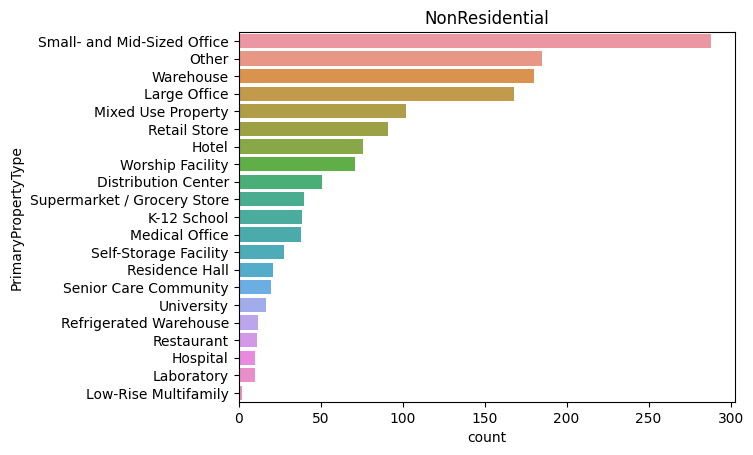

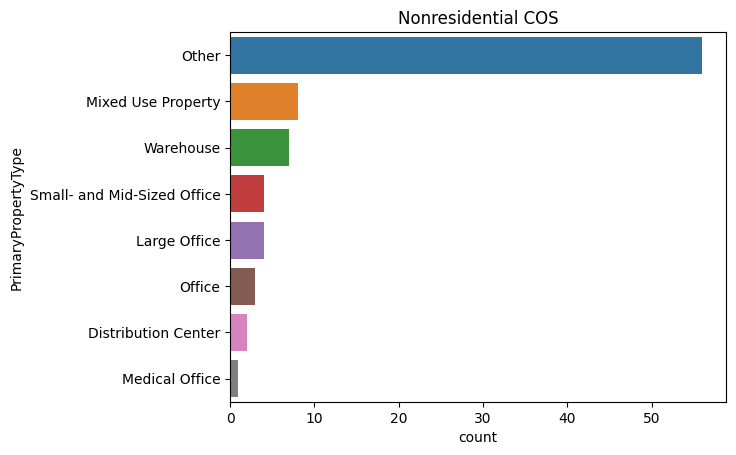

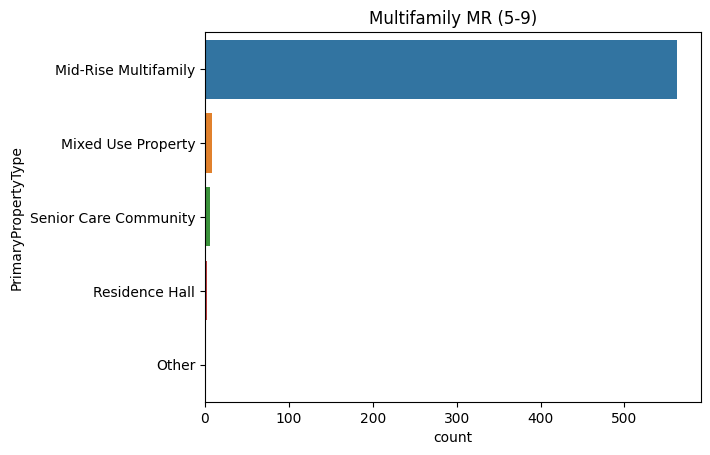

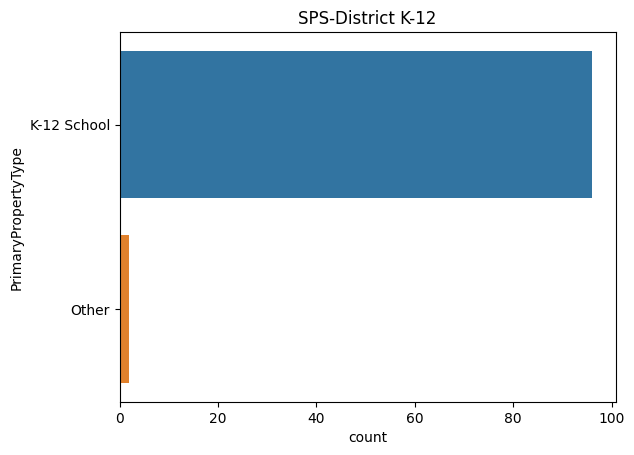

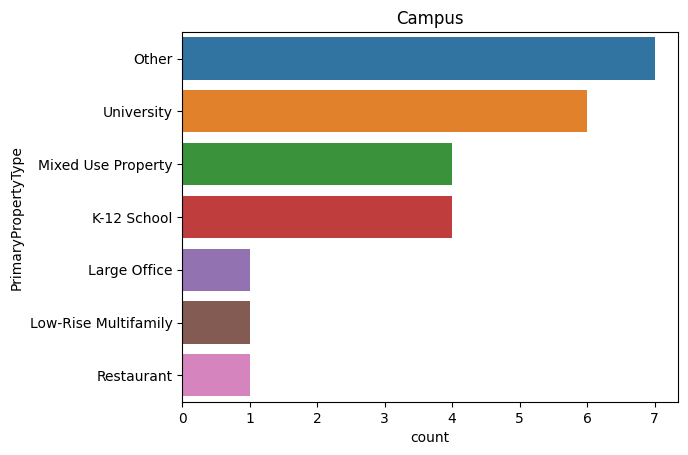

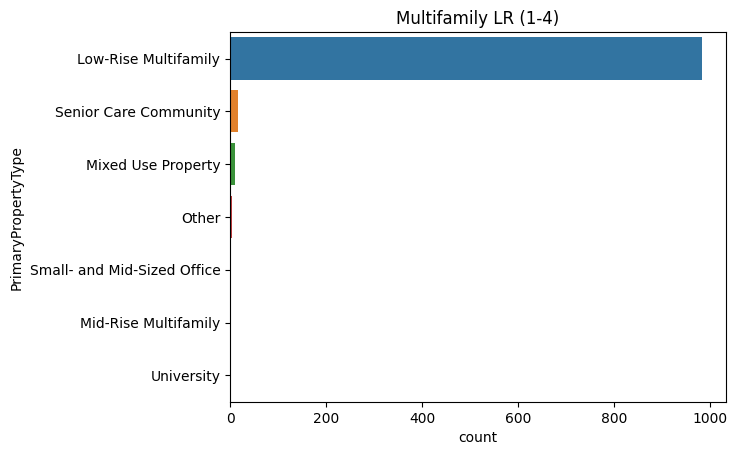

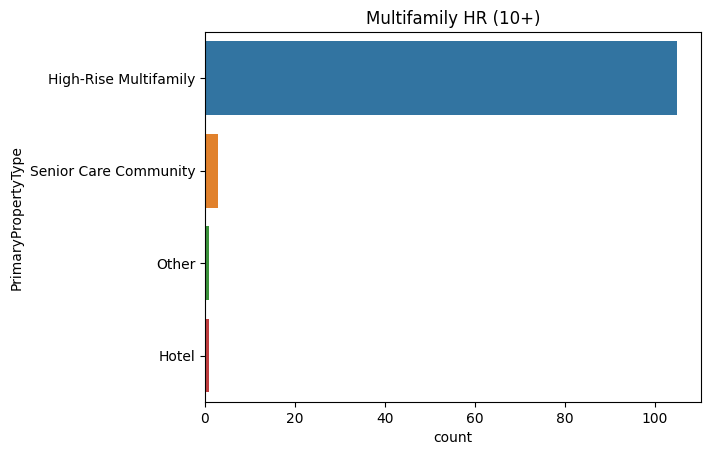

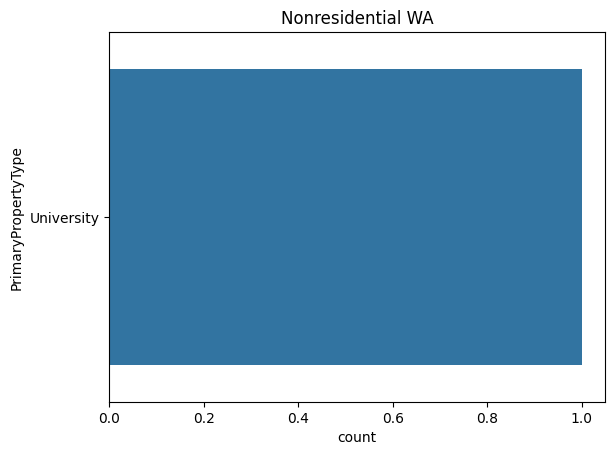

In [13]:
for elem in df['BuildingType'].unique():
    plt.title(elem)
    sns.countplot(data=df[df['BuildingType']==elem], y='PrimaryPropertyType', order=df[df['BuildingType']==elem]['PrimaryPropertyType'].value_counts().index)
    plt.show()

In [58]:
df

OSEBuildingID DataYear        BuildingType PrimaryPropertyType  \
0                 1     2016      NonResidential               Hotel   
1                 2     2016      NonResidential               Hotel   
2                 3     2016      NonResidential               Hotel   
3                 5     2016      NonResidential               Hotel   
4                 8     2016      NonResidential               Hotel   
...             ...      ...                 ...                 ...   
3371          50222     2016  Nonresidential COS              Office   
3372          50223     2016  Nonresidential COS               Other   
3373          50224     2016  Nonresidential COS               Other   
3374          50225     2016  Nonresidential COS  Mixed Use Property   
3375          50226     2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
0                    Mayflower park hotel     405 Olive way  Seattle    WA   
1                         Paramount Hotel   724 Pine street  Seattle    WA   
2                 5673-The Westin Seattle   1900 5th Avenue  Seattle    WA   
3                               HOTEL MAX    620 STEWART ST  Seattle    WA   
4             WARWICK SEATTLE HOTEL (ID8)     401 LENORA ST  Seattle    WA   
...                                   ...               ...      ...   ...   
3371                Horticulture building  1600 S Dakota St  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  ...  Electricity(kWh)  \
0     98101.0                    0659000030  ...      1.156514e+06   
1     98101.0                    0659000220  ...      9.504252e+05   
2     98101.0                    0659000475  ...      1.451544e+07   
3     98101.0                    0659000640  ...      8.115253e+05   
4     98121.0                    0659000970  ...      1.573449e+06   
...       ...                           ...  ...               ...   
3371      NaN                    1624049080  ...      1.536550e+05   
3372      NaN                    3558300000  ...      1.162210e+05   
3373      NaN                    1794501150  ...      5.252517e+05   
3374      NaN                    7883603155  ...      1.022480e+05   
3375      NaN                    7857002030  ...      1.267744e+05   

     Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
0         3.946027e+06        12764.529300      1.276453e+06        False   
1         3.242851e+06        51450.816410      5.145082e+06        False   
2         4.952666e+07        14938.000000      1.493800e+06        False   
3         2.768924e+06        18112.130860      1.811213e+06        False   
4         5.368607e+06        88039.984380      8.803998e+06        False   
...                ...                 ...               ...          ...   
3371      5.242709e+05         3254.750244      3.254750e+05         True   
3372      3.965461e+05         5537.299805      5.537300e+05        False   
3373      1.792159e+06        39737.390630      3.973739e+06        False   
3374      3.488702e+05         3706.010010      3.706010e+05        False   
3375      4.325542e+05         7203.419922      7.203420e+05        False   

      Comments              ComplianceStatus  Outlier  TotalGHGEmissions  \
0          NaN                     Compliant      NaN             249.98   
1          NaN                     Compliant      NaN             295.86   
2          NaN                     Compliant      NaN            2089.28   
3          NaN                     Compliant      NaN             286.43   
4          NaN                     Compliant      NaN     

In [41]:
df[numerical_features ]

DataYear  ZipCode  CouncilDistrictCode  Latitude  Longitude  \
0         2016  98101.0                    7  47.61220 -122.33799   
1         2016  98101.0                    7  47.61317 -122.33393   
2         2016  98101.0                    7  47.61393 -122.33810   
3         2016  98101.0                    7  47.61412 -122.33664   
4         2016  98121.0                    7  47.61375 -122.34047   
...        ...      ...                  ...       ...        ...   
3371      2016      NaN                    2  47.56722 -122.31154   
3372      2016      NaN                    2  47.59625 -122.32283   
3373      2016      NaN                    7  47.63644 -122.35784   
3374      2016      NaN                    1  47.52832 -122.32431   
3375      2016      NaN                    2  47.53939 -122.29536   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3371                1.0               1             12294                   0   
3372                1.0               1             16000                   0   
3373                1.0               1             13157                   0   
3374                1.0               1             14101                   0   
3375                1.0               1             18258                   0   

      PropertyGFABuilding(s)  ...  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                      88434  ...         7.226362e+06           7.456910e+06   
1                      88502  ...         8.387933e+06           8.664479e+06   
2                     759392  ...         7.258702e+07           7.393711e+07   
3                      61320  ...         6.794584e+06           6.946800e+06   
4                     113580  ...         1.417261e+07           1.465650e+07   
...                      ...  ...                  ...                    ...   
3371                   12294  ...         8.497457e+05           9.430032e+05   
3372                   16000  ...         9.502762e+05           1.053706e+06   
3373                   13157  ...         5.765898e+06           6.053764e+06   
3374                   14101  ...         7.194712e+05           7.828413e+05   
3375                   18258  ...         1.152896e+06           1.293722e+06   

      SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0         2003882.00      1.156514e+06       3.946027e+06        12764.529300   
1               0.00      9.504252e+05       3.242851e+06        51450.816410   
2        21566554.00      1.451544e+07       4.952666e+07        14938.000000   
3         2214446.25      8.115253e+05       2.768924e+06        18112.130860   
4               0.00      1.573449e+06       5.368607e+06        88039.984380   
...              ...               ...                ...                 ...   
3371            0.00      1.536550e+05       5.242709e+05         3254.750244   
3372            0.00      1.162210e+05       3.965461e+05         5537.299805   
3373            0.00      5.252517e+05       1.792159e+06        39737.390630   
3374            0.00      1.022480e+05       3.488702e+05         3706.010010   
3375            0.00      1.267744e+05       4.325542e+05         7203.419922   

      NaturalGas(kBtu)  Comments  TotalGHGEmissions  GHGEmissionsIntensity  
0         1.276453e+06       NaN             249.98                   2.83  
1         5.145082e+06       NaN             295.86                   2.86  
2         1.493800e+06     

In [59]:
encoder = LabelEncoder()
scaler = StandardScaler()